In [137]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
# from IPython.display import clear_output
# !pip install pandas tqdm torch scikit-learn
# clear_output()

In [139]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import models
from utils import save_model, load_model, upload_models_hf
from data.dataset import PatientDataset

In [141]:
images_path = "dataset/reduced/train"
labels_path = "dataset/reduced/train.csv"
batch_size = 1
model_type = "cnn"
cuda = False
lr = 1e-3
epochs = 100
depth = 64 # number of CT slices

In [142]:
entries = os.listdir(images_path)
patient_ids = [int(entry) for entry in entries if os.path.isdir(os.path.join(images_path, entry))]

df = pd.read_csv(labels_path)
df = df[df['patient_id'].isin(patient_ids)]
print(df.shape)

(2886, 6)


In [143]:
# Split the dataset into train, validation, and test sets
train_data, val_test_data = train_test_split(df, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(val_test_data, test_size=0.5, random_state=42)

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(2308, 6)
(289, 6)
(289, 6)


In [144]:
train_data.head()

,patient_id,bowel,extravastion,kidney,liver,spleen
1426,38343,0,1,0,0,1
964,29412,0,0,0,0,0
2608,63193,0,0,0,0,0
662,23709,0,0,0,0,0
2408,58547,0,0,0,0,0


In [145]:
train_dataset = PatientDataset(images_path, train_data, n_slices=depth)
val_dataset = PatientDataset(images_path, val_data, n_slices=depth)
test_dataset = PatientDataset(images_path, test_data, n_slices=depth)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# get one sample
inputs, labels = train_dataset[0]

print(inputs.shape)
print(labels.shape)

torch.Size([1, 64, 128, 128])
torch.Size([5])


In [146]:
if model_type == "cnn":
    model = models.ConvNet3D(
        in_channels=inputs.shape[0],
        out_channels=labels.shape[0],
        depth=inputs.shape[1],
        height=inputs.shape[2],
        width=inputs.shape[3],
    )
elif model_type == "unet":
    model = ...
else:
    raise ValueError("Invalid model selected for training.")

if cuda:
    model = model.cuda()

# test save and loader functions
os.makedirs("checkpoints", exist_ok = True)
save_model(model, "checkpoints/test.pth")
load_model(model, "checkpoints/test.pth")
os.remove("checkpoints/test.pth")

criterion = nn.BCEWithLogitsLoss()  # multi-label classification
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_losses = []
val_losses = []

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

best_vloss = 1_000_000.

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_vloss = 0.0
    batch_loss = 0.0

    pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    for i, (inputs, labels) in pbar:
        if cuda:
            inputs, labels = inputs.cuda(), labels.cuda()

        # zero gradients for every batch
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        batch_loss += loss.item()
        if i % 10 == 0:
            batch_loss = batch_loss / 10 # loss per batch
            pbar.set_postfix({'loss': round(batch_loss, 5)})
            batch_loss = 0.0
        
        break

    avg_loss = running_loss / (i + 1)
    train_losses.append((epoch, avg_loss))

    print("Validation...")
    model.eval()
    with torch.no_grad():
        for (inputs, labels) in val_dataloader:
            if cuda:
                inputs, labels = inputs.cuda(), labels.cuda()
                
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            running_vloss += loss.item()
            break

    avg_vloss = running_vloss / len(val_dataloader)
    val_losses.append((epoch, avg_vloss))

    print('[LOSS] train {} val {}'.format(avg_loss, avg_vloss))
    
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        save_model(model, 'checkpoints/model_{}_{}'.format(timestamp, epoch))

    if epoch != 0 and epoch % 5 == 0:
        save_model(model, f"checkpoints/model-e{epoch}.pth")

Model saved to checkpoints/test.pth
Model loaded from checkpoints/test.pth


  0%|          | 0/2308 [00:06<?, ?it/s, loss=0.0712]


Validation...
LOSS train 0.7121667504310608 valid 7.578617599905568e-05
Model saved to checkpoints/model_20240413_010437_0


  0%|          | 0/2308 [00:06<?, ?it/s, loss=0]


Validation...
LOSS train 0.0 valid 0.0
Model saved to checkpoints/model_20240413_010437_1


  0%|          | 0/2308 [00:05<?, ?it/s, loss=2.96]


Validation...
LOSS train 29.557920074462892 valid 0.0


  0%|          | 0/2308 [00:06<?, ?it/s, loss=0]


Validation...
LOSS train 0.0 valid 0.0


  0%|          | 0/2308 [00:06<?, ?it/s, loss=0]


Validation...
LOSS train 0.0 valid 0.0


  0%|          | 0/2308 [00:06<?, ?it/s, loss=0]


Validation...


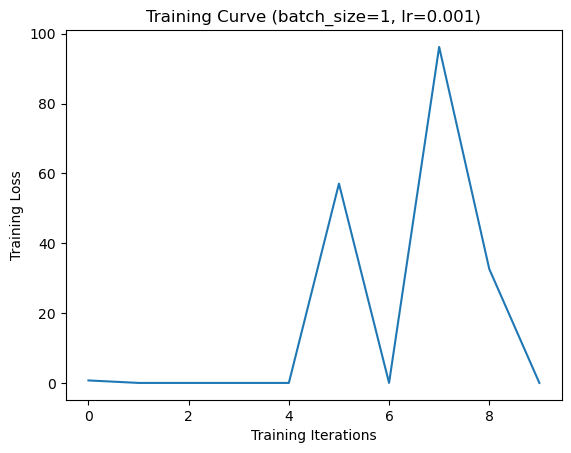

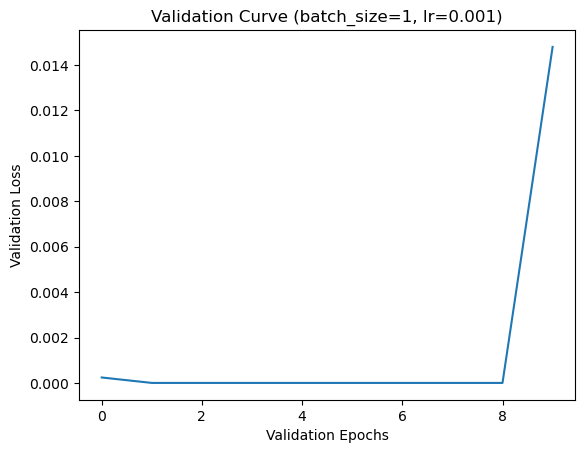

In [ ]:
t_iters, t_loss = list(zip(*train_losses))
plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, lr))
plt.plot(t_iters, t_loss, label="Train")
plt.xlabel("Training Iterations")
plt.ylabel("Training Loss")
plt.show()

v_iters, v_loss = list(zip(*val_losses))
plt.title("Validation Curve (batch_size={}, lr={})".format(batch_size, lr))
plt.plot(v_iters, v_loss, label="Validation")
plt.xlabel("Validation Epochs")    
plt.ylabel("Validation Loss")
plt.show()

# Upload Model

In [135]:
upload_models_hf("checkpoints/", "Pie31415", "abd-trauma-models")

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model-e0.pth:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

model-e5.pth:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

Model successfully uploaded to Pie31415/abd-trauma-models


# Inference

In [ ]:
def inference(model, inputs):
    with torch.no_grad():
        outputs = model(inputs)
        pred = (outputs > 0.5).int()
    
    return pred